# Leaspy model for comparison

In [2]:
import torch
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
# import leaspy

path_leaspy = '/home/benoit.sautydechalon/leaspy/'
sys.path.append(path_leaspy)

from leaspy import Leaspy, Data, IndividualParameters, AlgorithmSettings

### MDS

In [107]:
data = pd.DataFrame(index=[ids, times], columns=['mds1', 'mds2'])
data['mds1'] = mds1
data['mds2'] = mds2
data.index.set_names(['ID','TIME'], inplace=True)
data

mds1      mds2
ID   TIME                      
3001 65.084  0.500000  0.133333
     65.161  0.571429  0.133333
     65.411  0.500000  0.133333
     65.661  0.500000  0.200000
     65.911  0.571429  0.200000
...               ...       ...
3467 67.413  0.500000  0.733333
     67.581  0.714286  0.800000
     67.913  0.357143  0.733333
     68.413  0.357143  0.666667
     68.913  0.357143  0.733333

[3000 rows x 2 columns]

### Simulated data

In [3]:
path = '../simulated_study'
data = '/simulated_data_metric_1'

times = [time[0] for time in pd.read_csv(path+data+'/X.csv', header=None).values]
logistic = [score[0] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
sum_logistic = [score[1] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+data+'/group.csv', header=None).values]

In [4]:
data = pd.DataFrame(index=[ids, times], columns=['logistic', 'sum_logistic'])
data['logistic'] = logistic
data['sum_logistic'] = sum_logistic
data.index.set_names(['ID','TIME'], inplace=True)
data

logistic  sum_logistic
ID  TIME                            
0   69.76381  0.757825      0.449024
    70.16381  0.762448      0.519819
    70.56381  0.723426      0.501171
    70.96381  0.763044      0.526731
    71.36381  0.804602      0.495426
...                ...           ...
299 70.44248  0.467512      0.922183
    70.84248  0.520318      0.930383
    71.24248  0.504897      0.910310
    71.64248  0.511996      0.957397
    72.04248  0.494403      0.943727

[4200 rows x 2 columns]

### Pruned data

In [20]:
path = '../simulated_study'
path_data = '/simulated_data_3'

times = [time[0] for time in pd.read_csv(path+path_data+'/X.csv', header=None).values]
logistic = [score[0] for score in pd.read_csv(path+path_data+'/Y_pruned.csv', header=None).values]
sum_logistic = [score[1] for score in pd.read_csv(path+path_data+'/Y_pruned.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+path_data+'/group.csv', header=None).values]

In [21]:
data_pruned = pd.DataFrame(index=[ids, times], columns=['logistic', 'sum_logistic'])
data_pruned['logistic'] = logistic
data_pruned['sum_logistic'] = sum_logistic
data_pruned.index.set_names(['ID','TIME'], inplace=True)
data_pruned

logistic  sum_logistic
ID  TIME                             
0   56.340559       NaN           NaN
    56.840559       NaN           NaN
    57.340559  0.252891      0.440507
    57.840559       NaN           NaN
    58.340559  0.261381      0.477437
...                 ...           ...
199 72.828851       NaN           NaN
    73.328851  0.694015      0.922010
    73.828851  0.699477      0.911478
    74.328851  0.686855      0.922275
    74.828851       NaN           NaN

[2000 rows x 2 columns]

## Leaspy model

In [22]:
n_iter = 8000
n_sources = 1

settings = AlgorithmSettings('mcmc_saem', n_iter=n_iter, progress_bar=True)
settings.set_logs(path='logs_small_model',  plot_periodicity=50,save_periodicity=10,
                           console_print_periodicity=None,overwrite_logs_folder=True) 
# Fitting the model

leaspy = Leaspy('linear')
leaspy.model.load_hyperparameters({'source_dimension': n_sources})

data_leaspy = Data.from_dataframe(data)

leaspy.fit(data_leaspy, settings)
print(leaspy.model.parameters)


...overwrite logs folder...
|##################################################|   8000/8000 iterations
The standard deviation of the noise at the end of the calibration is:
0.0232

Calibration took: 12min 46s
{'g': tensor([0.5252, 0.6962]), 'v0': tensor([-5.3492, -4.7460]), 'betas': tensor([[-0.1456]]), 'tau_mean': tensor(72.1175), 'tau_std': tensor(23.9615), 'xi_mean': tensor(0.), 'xi_std': tensor(0.5050), 'sources_mean': tensor(0.), 'sources_std': tensor(1.), 'noise_std': tensor(0.0232)}


In [23]:
settings_2 = AlgorithmSettings('mode_real', n_jobs=2, use_jacobian=True)

#data_leaspy = Data.from_dataframe(data_pruned)
individual_parameters = leaspy.personalize(data_leaspy, settings_2)
individual_parameters.to_dataframe().to_csv('joint_study_small_param.csv')


The standard deviation of the noise at the end of the personalization is:
0.0231

Personalization mode_real took: 8s


In [27]:
individual_parameters = pd.read_csv('joint_study_small_param.csv').set_index('ID')

In [28]:
individual_parameters.describe()

,tau,xi,sources
count,300.000000,300.000000,300.000000
mean,71.563399,0.191147,-0.036693
std,15.701539,0.420817,0.990913
min,30.307701,-0.749850,-2.240443
25%,60.238348,-0.108939,-0.748911
50%,73.257198,0.137791,0.037339
75%,81.597889,0.447163,0.689505
max,105.003319,1.723995,2.015276


In [34]:
data['TIME'] = data.index.get_level_values(1)
data['ID'] = data.index.get_level_values(0)
data = data.set_index('ID')

In [36]:
from utils import predict_scores

predicted_scores = predict_scores(data, individual_parameters, leaspy)
abs(predicted_scores - data).describe()

,TIME,logistic,sum_logistic
count,2000.0,2000.000000,2000.000000
mean,0.0,0.012761,0.013284
std,0.0,0.010009,0.010802
min,0.0,0.000003,0.000002
25%,0.0,0.005130,0.005171
50%,0.0,0.010525,0.010910
75%,0.0,0.018127,0.018956
max,0.0,0.061142,0.117867


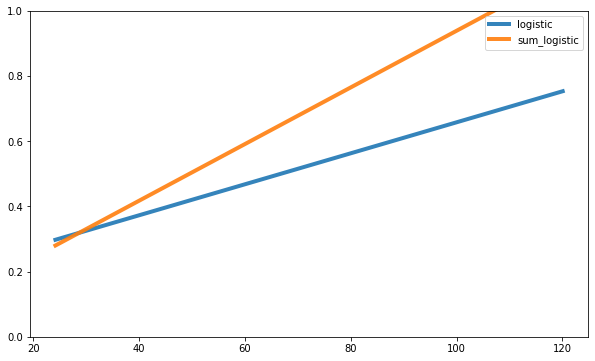

In [25]:
model = leaspy.model

labels = model.features
fig, ax = plt.subplots(figsize=(10, 6))

cmap = matplotlib.cm.get_cmap('viridis_r')
colors = [cmap(11*i) for i in range(121)]

mean_time = model.parameters['tau_mean']
std_time = max(model.parameters['tau_std'], 4)
timepoints = np.linspace(mean_time - 2* std_time, mean_time + 2* std_time, 100)
timepoints = torch.Tensor([timepoints])

mean_trajectory = model.compute_mean_traj(timepoints).detach().numpy()

for i in range(len(labels)):
    ax.plot(timepoints[0, :].detach().numpy(), mean_trajectory[0, :, i], label=labels[i],
            linewidth=4, alpha=0.9)  # , c=colors[i])
    
ax.legend()

plt.ylim((0,1))
plt.show()

In [13]:
true_individual_parameters = pd.read_csv(path+'/simulated_data_1/true_individual_parameters.csv').set_index('Unnamed: 0')
true_individual_parameters.index.name = 'ID'
true_individual_parameters

,xi,tau,source
ID,,,
0,-0.042195,65.204252,14.855125
1,0.277844,72.614263,-4.664902
2,-0.448266,62.417224,11.654640
3,0.687274,78.584107,10.606578
4,0.474100,88.115856,-4.351091
...,...,...,...
295,-0.266133,89.821899,-14.452402
296,0.578161,85.970123,-4.993718
297,0.419483,77.756186,-1.596787


In [14]:
individual_parameters

,tau,xi,sources
ID,,,
0,73.896591,1.106323,1.846798
1,74.144577,0.331615,-0.021941
2,67.448364,-0.197566,-0.699422
3,72.285034,-0.257968,-1.415787
4,77.385406,0.243249,0.814463
...,...,...,...
295,55.033245,0.411913,-0.553708
296,85.238091,0.030626,-1.248336
297,92.315956,0.011051,1.041001


In [29]:
abs(true_individual_parameters - individual_parameters).describe()

,source,sources,tau,xi
count,0.0,0.0,300.000000,300.000000
mean,NaN,NaN,16.290012,0.503500
std,NaN,NaN,11.039638,0.390073
min,NaN,NaN,0.214407,0.000187
25%,NaN,NaN,7.583963,0.216354
50%,NaN,NaN,14.494875,0.396142
75%,NaN,NaN,22.746722,0.751932
max,NaN,NaN,52.247168,1.787517


## 2true_individual_parametersing the convergence

In [85]:
data['TIME'] = data.index.get_level_values(1)
data['ID'] = data.index.get_level_values(0)
data = data.set_index('ID')

IndexError: Too many levels: Index has only 1 level, not 2

In [99]:
from utils import predict_scores

ind = individual_parameters
ind.index = [int(sub) for sub in ind.index]

predicted = predict_scores(data,ind,leaspy)
predicted.head()

,TIME,logistic,sum_logistic
ID,,,
0,83.411609,0.696466,0.826584
0,83.911609,0.701524,0.829725
0,84.411609,0.706533,0.832821
0,84.911609,0.711493,0.835871
0,85.411609,0.716402,0.838877


In [100]:
abs(predicted-data).drop('TIME',axis=1).describe()

,logistic,sum_logistic
count,800.000000,800.000000
mean,0.053616,0.055308
std,0.041433,0.039618
min,0.000007,0.000299
25%,0.019999,0.022586
50%,0.043995,0.048692
75%,0.079350,0.080251
max,0.261044,0.222414
